<a href="https://colab.research.google.com/github/andrewpark19/4thyear-FYP/blob/main/ViT_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 20 15:55:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [3]:
#import main libraries

import cv2
import numpy as np
import pandas as pd
import albumentations as alb
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator

In [4]:
#unzip data which has been stored in google drive

#replace PATH with wherever the data has been stored for replication

!unzip /content/drive/MyDrive/melanoma_data/isic_2020/train_2020/train_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/test_2020/test_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2019/train_2019/train_2019.zip > /dev/null


In [5]:
#PATH for where the unzipped images will be resaved for easier access
train2020_dir = '/content/train_2020'
test2020_dir = '/content/test_2020'
train2019_dir = '/content/train_2019' 

#PATH for overarching data directory
data_dir = '/content/drive/MyDrive/melanoma_data'

def get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False):

    ###Training Data
    #2020 Data
    df_train = pd.read_csv(os.path.join(data_dir, r'isic_2020','train_2020.csv')) #path to train_2020.csv
    df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(train2020_dir, f'{x}.jpg'))

    # #2019 data
    df_train2 = pd.read_csv(os.path.join(data_dir, r'isic_2019', 'train_2019.csv')) #path to train_2019.csv
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(train2019_dir, f'{x}.jpg'))

    # #Change Labels to match
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))

    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

    # ###Test Data
    df_test = pd.read_csv(os.path.join(data_dir,r'isic_2020', 'test_2020.csv'))
    df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(test2020_dir, f'{x}.jpg'))

    if use_meta:
        df_train, df_test, meta_features, n_meta_features = get_meta_data(df_train, df_test)
    else:
        meta_features = None
        n_meta_features = 0

    diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
    df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
    mel_idx = diagnosis2idx['melanoma']

    return df_train, df_test, meta_features, n_meta_features, mel_idx
  

df_train, df_test, _, _, mel_idx = get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False)

In [6]:
df_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,filepath
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,8,0,6000,4000,/content/train_2020/ISIC_2637011.jpg
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,8,0,6000,4000,/content/train_2020/ISIC_0015719.jpg
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,7,6,1872,1053,/content/train_2020/ISIC_0052212.jpg
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,8,0,1872,1053,/content/train_2020/ISIC_0068279.jpg
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,8,11,6000,4000,/content/train_2020/ISIC_0074268.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
58452,ISIC_0073247,-1,female,85.0,head/neck,BCC,benign,1,19,1024,1024,/content/train_2019/ISIC_0073247.jpg
58453,ISIC_0073248,-1,male,65.0,anterior torso,BKL,benign,2,7,1024,1024,/content/train_2019/ISIC_0073248.jpg
58454,ISIC_0073249,-1,male,70.0,lower extremity,melanoma,malignant,6,9,1024,1024,/content/train_2019/ISIC_0073249.jpg
58455,ISIC_0073251,-1,female,55.0,palms/soles,nevus,benign,7,15,1024,1024,/content/train_2019/ISIC_0073251.jpg


In [7]:
#Reconfiguring into binary classificaition problem
df_train.loc[df_train.diagnosis == 'BCC', 'benign_malignant'] = 'malignant' 
df_train.loc[df_train.diagnosis == 'SCC', 'benign_malignant'] = 'malignant' 

In [8]:
#Hyperparameters
SEED = 42

num_classes = 1
input_shape = (72, 72, 3)

learning_rate = 0.0005
weight_decay = 0.0001
batch_size = 32
patience= 20
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [9]:
#Loading data into Keras

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rescale=1/255.0,
                                   )

generator = train_datagen.flow_from_dataframe(     
    dataframe=df_train,  
    directory=None,
    x_col='filepath', # name of col in data frame that contains file names
    y_col="benign_malignant", # name of col with labels 
    batch_size=42997,
    shuffle=True,
    #save_to_dir=saveDir,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='binary'
)


imgs,labels = next(generator)
print(f"imgs.shape:{imgs.shape},labels.shape:{labels.shape}")


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 15460 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 42997 validated image filenames belonging to 2 classes.
imgs.shape:(42997, 72, 72, 3),labels.shape:(42997,)


In [10]:
from sklearn.model_selection import train_test_split

#Stratified splitting of training and validation data
X_train, X_val, y_train, y_val = train_test_split(imgs,labels, test_size=0.25,stratify=labels, random_state=SEED)
print(f"X_train.shape:{X_train.shape},X_val.shape:{X_val.shape}")
print(f"y_train.shape:{y_train.shape},y_val.shape:{y_val.shape}")

X_train.shape:(32247, 72, 72, 3),X_val.shape:(10750, 72, 72, 3)
y_train.shape:(32247,),y_val.shape:(10750,)


In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation) #dropout orginally 0.5
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5) #dropout orginally 0.5
    # Classify outputs.
    logits = layers.Dense(num_classes, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


TensorShape([1, 144, 108])

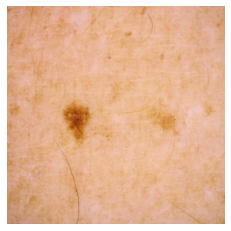

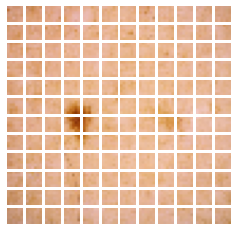

In [12]:
#Visualize patches of ViT

image_path = '/content/train_2020/ISIC_0015719.jpg'
image_size=72

plt.figure(figsize=(4, 4))
img = plt.imread(image_path)
plt.imshow(img)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

patches.shape

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 144, 64)     128         ['patch_encoder[0][0]']          
 alization)                                                                                   

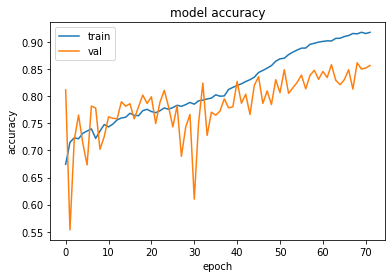

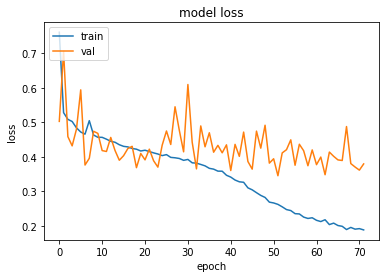

In [13]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(y_train),
                                            y= y_train)
weights = dict(zip(np.unique(y_train), weights))


def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
  model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[
          'accuracy',
      ],
  )
  model_name = "melanoma_ViT.h5"
  log_dir = os.path.join(os.getcwd(), 'logs')
  filepath='ViT.{epoch:02d}-{val_loss:.4f}.h5'
  ck_path = os.path.join(log_dir, filepath)
  if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
  mc = keras.callbacks.ModelCheckpoint(ck_path, monitor='val_loss',save_best_only=True,save_weights_only=True)
  es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0) # when patience epoch val_loss not improve, stop train
  # tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
  callbacks = [es, mc]


  history = model.fit(
      x = X_train,
      y = y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=(X_val,y_val),
      # validation_split=0.1,
      shuffle=True,
      callbacks=callbacks,
      class_weight = weights,
  )

  # To see history keys for visualization
  print(history.history.keys())

  # save model and weight
  # model_path = os.path.join(log_dir, model_name)
  # model.save(model_path)

  return history


vit_classifier = create_vit_classifier()
vit_classifier.summary()
history = run_experiment(vit_classifier)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [14]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import PrecisionRecallDisplay



ypred = vit_classifier.predict(X_val)
ypred = ypred.argmax(axis=-1)

precision, recall, _ = precision_recall_curve(y_val, ypred)
print('AP:', average_precision_score(y_val, ypred, average='macro'))
print('ROC:', roc_auc_score(y_val, ypred))
print('AUC:', auc(recall, precision))

AP: 0.15916279069767442
ROC: 0.5
AUC: 0.5795813953488372
